### Home Credit Default Risk
#### Can you predict how capable each applicant is of repaying a loan?

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

<img src="loan.jpg">

### Data Description
Static data for all applications. One row represents one loan in our data sample.\
The target is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import  numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import lightgbm as lgbm
import scikitplot as skplt

### Data information

In [2]:
df=pd.read_csv('application_data.csv')

In [3]:
df.shape

(307511, 122)

In [4]:
df.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      307511 non-null int64
TARGET                          307511 non-null int64
NAME_CONTRACT_TYPE              307511 non-null object
CODE_GENDER                     307511 non-null object
FLAG_OWN_CAR                    307511 non-null object
FLAG_OWN_REALTY                 307511 non-null object
CNT_CHILDREN                    307511 non-null int64
AMT_INCOME_TOTAL                307511 non-null float64
AMT_CREDIT                      307511 non-null float64
AMT_ANNUITY                     307499 non-null float64
AMT_GOODS_PRICE                 307233 non-null float64
NAME_TYPE_SUITE                 306219 non-null object
NAME_INCOME_TYPE                307511 non-null object
NAME_EDUCATION_TYPE             307511 non-null object
NAME_FAMILY_STATUS              307511 non-null object
NAME_HOUSING_TYPE               307511 non-null object
REGION_

### Handle missing values

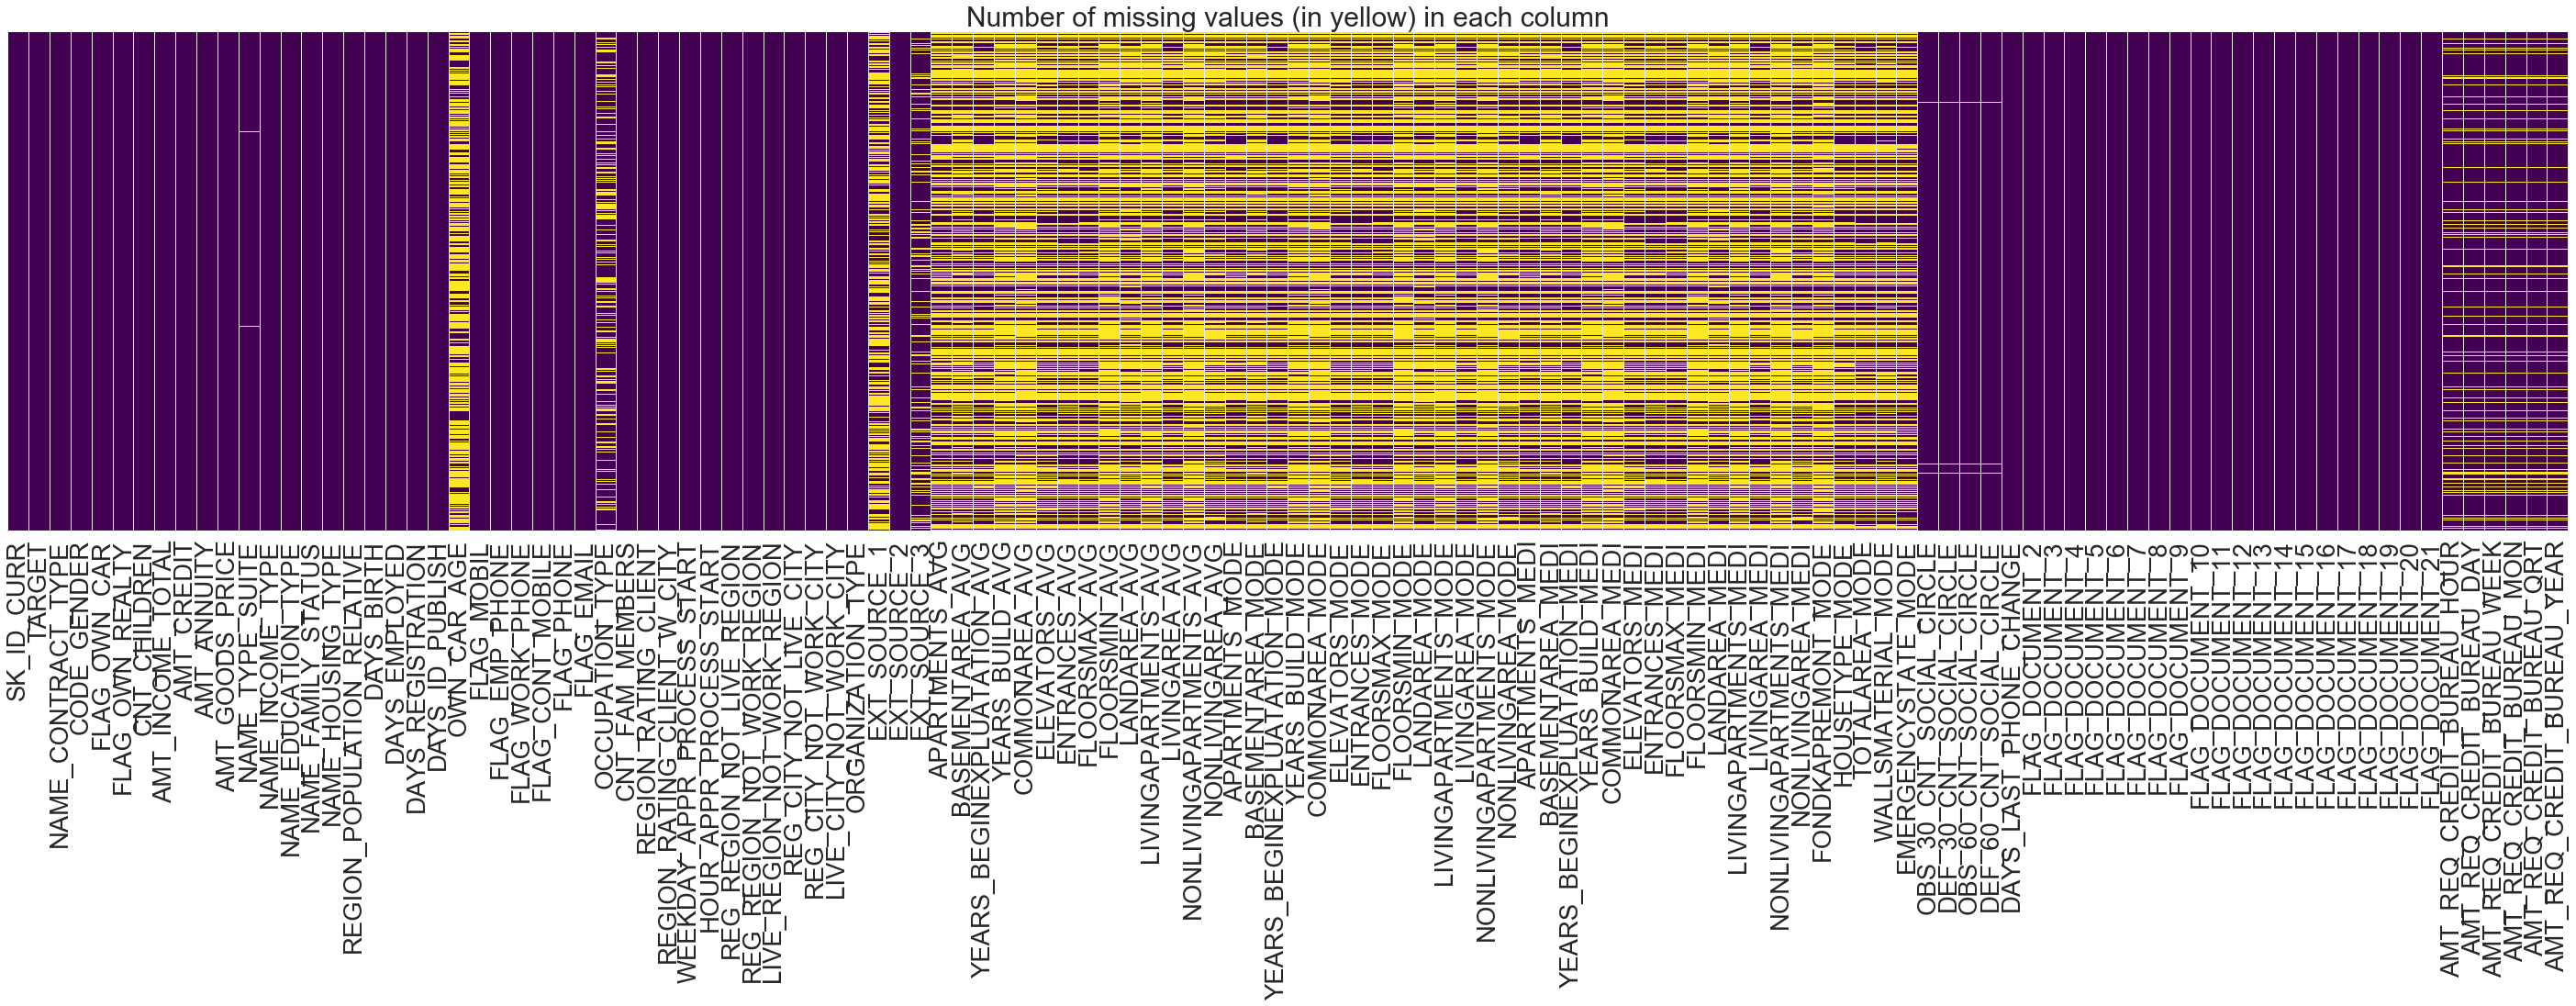

In [6]:
sns.set(font_scale=2.5)
fig,ax=plt.subplots(figsize=(50,10))
ax.set_title('Number of missing values (in yellow) in each column')
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis',xticklabels=True)

In [7]:
#Drop the columns with more than 40% null values
drop_columns=[column for column in df.columns if df[column].count()<0.6*len(df)]
df.drop(drop_columns,axis=1,inplace=True)

In [8]:
#fill null values in occupation column with 'NAN' as a new category
df['OCCUPATION_TYPE'].fillna('NAN',inplace=True)

In [9]:
#fill null values in the following columns with column mean value
for column in ['EXT_SOURCE_3','AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']:
    df[column].fillna(df[column].mean(),inplace=True)

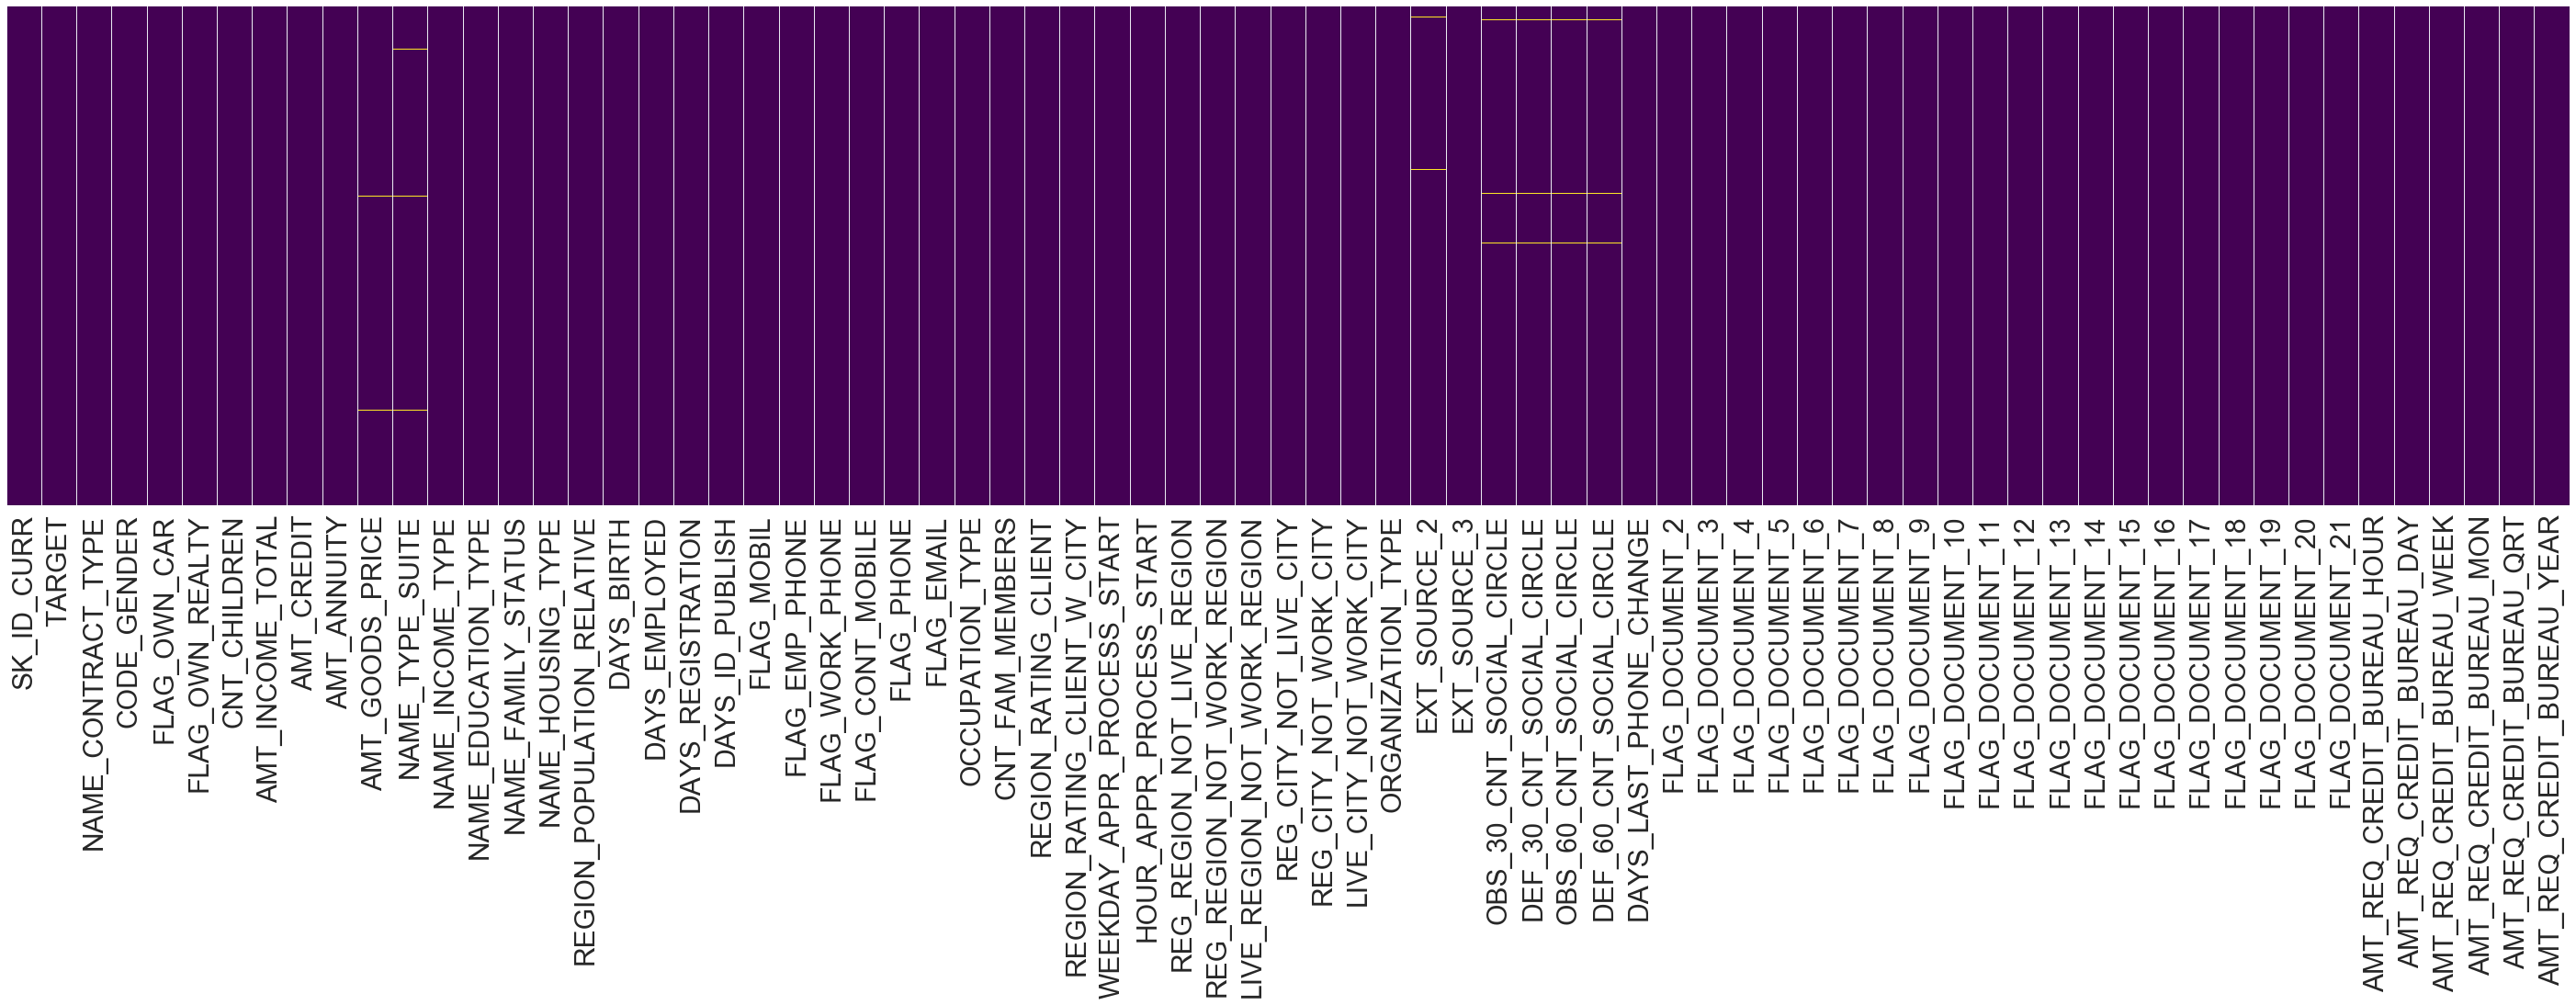

In [10]:
fig,ax=plt.subplots(figsize=(50,10))
ax.set_xticklabels(df.columns,fontdict={'fontsize':30})
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis',xticklabels=True)

In [11]:
#Drop the remaining rows with a missing value
df.dropna(inplace=True)

### Explanatory data analysis

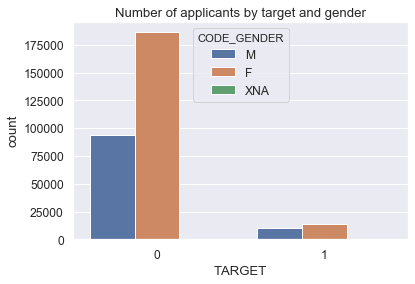

In [12]:
sns.set(font_scale=1.1)
fig,ax=plt.subplots()
ax.set_title('Number of applicants by target and gender')
sns.countplot(x='TARGET',data=df,hue='CODE_GENDER')

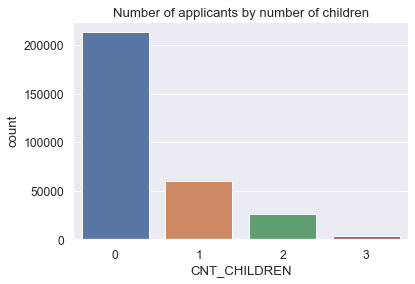

In [13]:
fig,ax=plt.subplots()
ax.set_title('Number of applicants by number of children')
sns.countplot(x='CNT_CHILDREN',data=df,order=df['CNT_CHILDREN'].value_counts().iloc[:4].index)

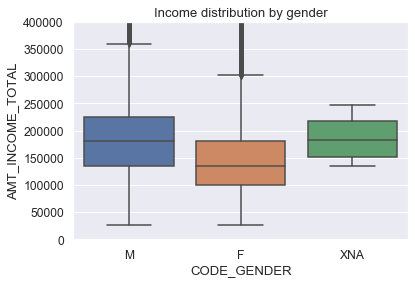

In [14]:
fig,ax=plt.subplots()
ax.set_ylim(top=400000)
ax.set_title('Income distribution by gender')
sns.boxplot(y='AMT_INCOME_TOTAL',x='CODE_GENDER',data=df)

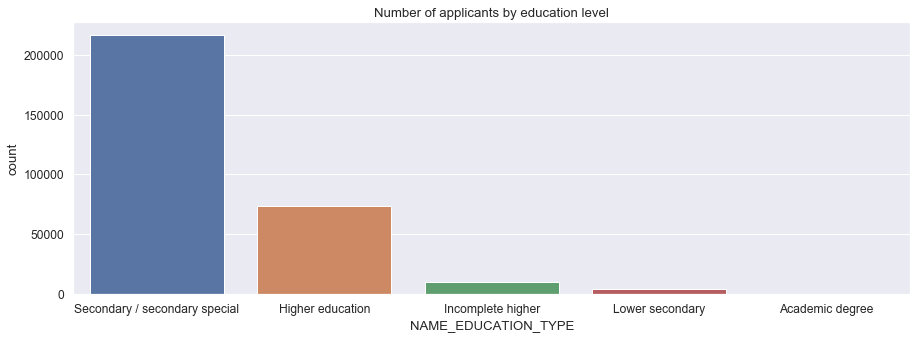

In [15]:
fig,ax=plt.subplots(figsize=(15,5))
ax.set_title('Number of applicants by education level')
sns.countplot(x='NAME_EDUCATION_TYPE',data=df)

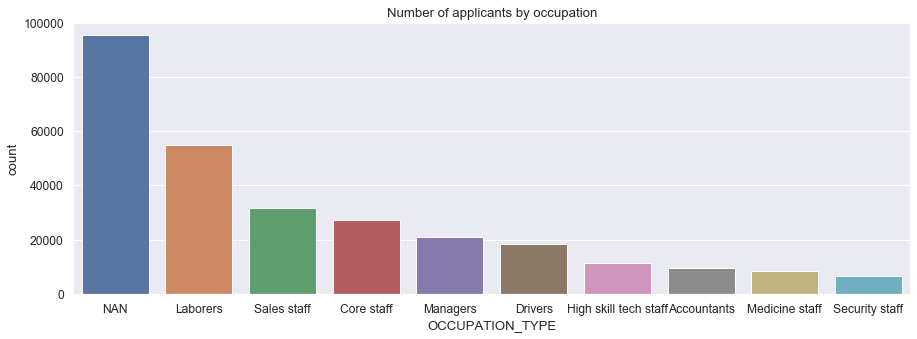

In [16]:
fig,ax=plt.subplots(figsize=(15,5))
ax.set_title('Number of applicants by occupation')
sns.countplot(df['OCCUPATION_TYPE'],order=df['OCCUPATION_TYPE'].value_counts().iloc[:10].index)

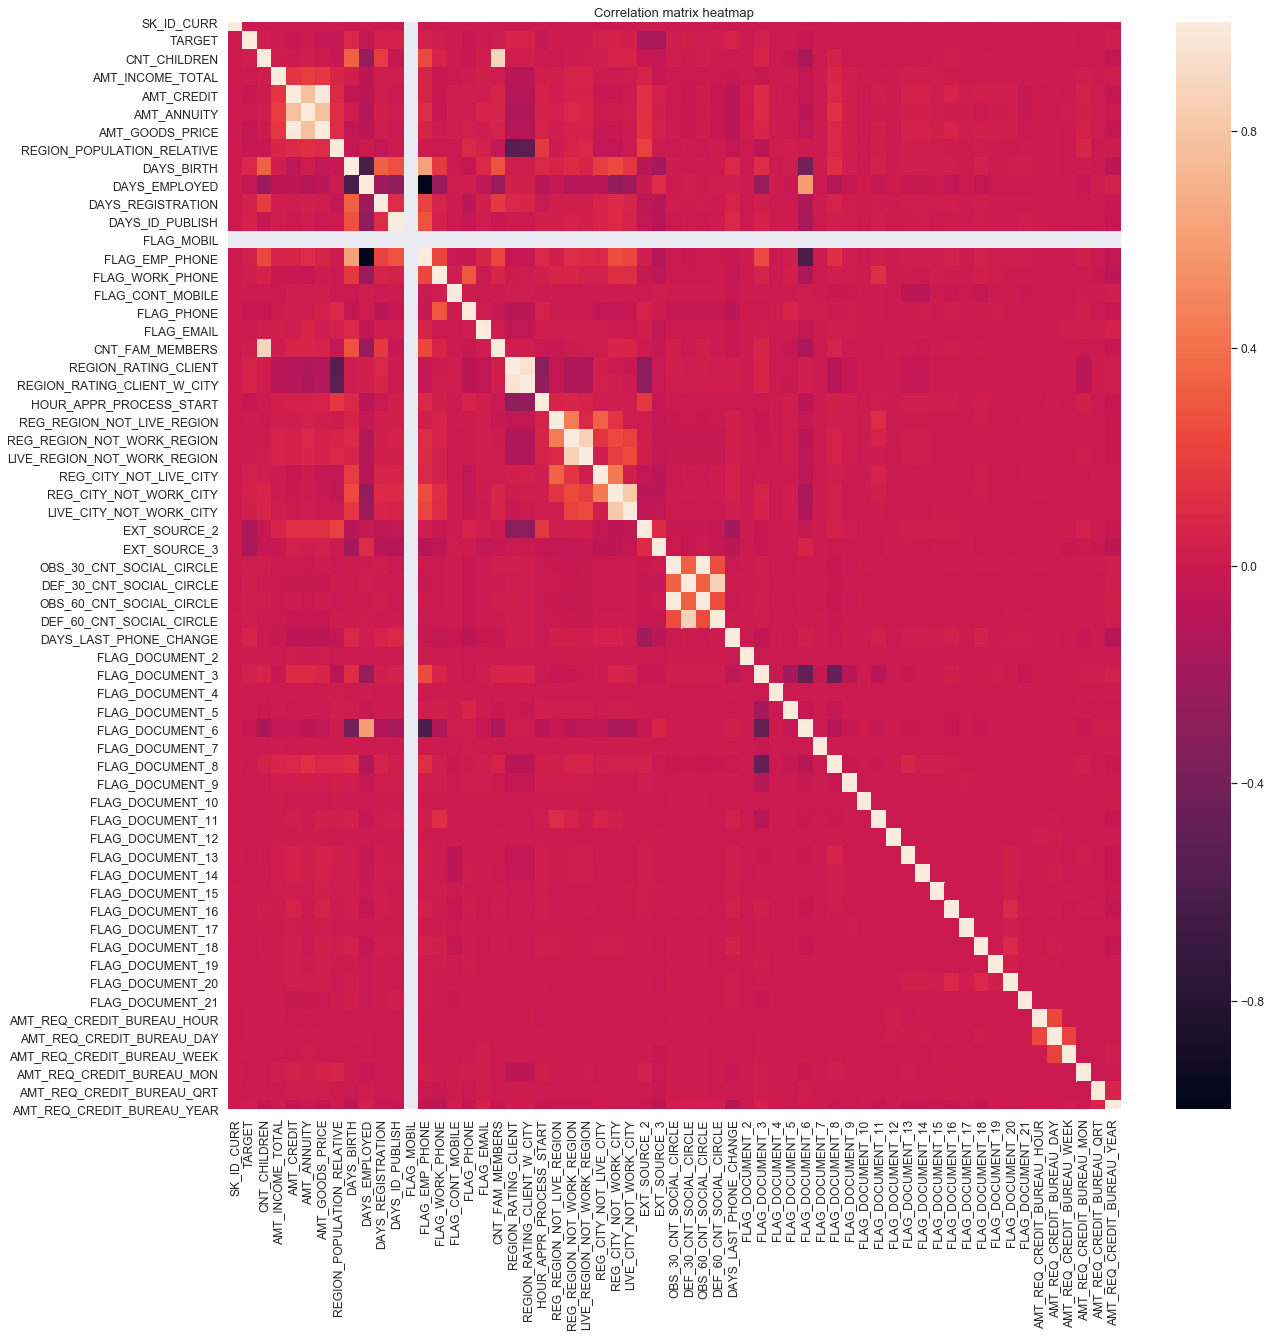

In [17]:
fig,ax=plt.subplots(figsize=(20,20))
ax.set_title('Correlation matrix heatmap')
sns.heatmap(df.corr())

### Handle categorial values

In [18]:
df=pd.get_dummies(df,drop_first=True)

### Split data into train and test sets

In [19]:
X=df.drop(['TARGET','SK_ID_CURR'],axis=1)
y=df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Build and evaluate various classification models with default hyperparameter values

In [20]:
models=[('logreg',LogisticRegression()),('dtc',DecisionTreeClassifier()),('rfc',RandomForestClassifier(n_estimators=10)),
        ('gnb',GaussianNB()),('lgbm',LGBMClassifier()),('xgbm',XGBClassifier())]
result={}
for model in models:
    model[1].fit(X_train,y_train)
    preds=model[1].predict_proba(X_test)
    score=roc_auc_score(y_test,preds[:,1])
    result[model[0]]=score
print (result)

C:\Users\aliba\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'logreg': 0.6179833634296023, 'dtc': 0.5367718511938067, 'rfc': 0.6325111456722213, 'gnb': 0.5975793570087604, 'lgbm': 0.7504947768089685, 'xgbm': 0.7459544430903572}


### Select the best model (highest ROC AUC score)

In [21]:
print (f'{max(result, key=result.get)} generated the highest roc auc score')

lgbm generated the highest roc auc score


### Hyperparameter tunning and cross validation on selected model

In [36]:
model=LGBMClassifier()
#limited hyperparameter tuning due to memory limitation
param_grid={'num_leaves':[10,15,25]}
grid=GridSearchCV(model,param_grid,cv=3,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)
grid.best_params_

{'num_leaves': 15}

### Make predictions and evaluate

In [37]:
grid.score(X_test,y_test)

0.7501720717492415

C:\Users\aliba\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


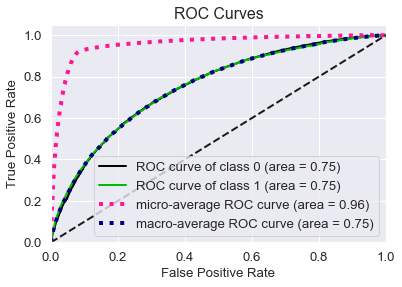

In [38]:
preds=grid.predict_proba(X_test)
#plot roc curve
skplt.metrics.plot_roc_curve(y_test,preds)